# Statistical Analysis of Bay Area Bike Share Data

> <b>1</b> Is Commuter ridership affected by Rain?
> 
> <b>2</b> Is Commuter ridership affected by Hot or Cold Temperatures?
>
> <b>3</b> Is Commuter ridership affected by Humidity?

In [1]:
%matplotlib inline

import matplotlib
import numpy as np
# from scipy import stats
# import scipy
import math
import matplotlib.pyplot as plt
import pandas as pd
from glob import glob
import datetime

import seaborn as sns
# sns.set()
sns.set_style('whitegrid')
sns.set_context("poster")

In [270]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:95% !important; }</style>"))

font = {'size'   : 50}
matplotlib.rc('font', **font)

TITLE_FONT_SIZE = 25
LABEL_FONT_SIZE = 15
TICK_FONT_SIZE  = 15

day_labels = ['MON','TUE','WED','THU','FRI','SAT','SUN']
day_labels_full = ['MONDAY','TUESDAY','WEDNESDAY','THURSDAY','FRIDAY','SATURDAY','SUNDAY']
month_labels = ['JAN','FEB','MAR','APR','MAY','JUN','JUL','AUG','SEP','OCT','NOV','DEC']
month_labels_full = ['JANUARY','FEBRUAARY','MARCH','APRIL','MAY','JUNE','JULY','AUGUST','SEPTEMBER','OCTOBER','NOVEMBER','DECEMBER']

sub_color = 'b'
sub_color_alt = 'm'
cust_color='r'
cust_color_alt='y'

commuter_color='g'
commuter_color_alt='#1daf1d'

commuter_am = '#ea54d9'     #OrRd
commuter_am_alt = '#9b8460' #OrRd_r

commuter_pm = '#b97ccc'     #PuRd
commuter_pm_alt = '#f4ad3a' #PuRd_r

FIG_SIZE = (15,6)
GRID_DIMS = 15

# Load Morning and Evening Commuter Trips Data
## Caltrain Super Station Only

In [3]:
super_station = [69, 70]

In [4]:
print('[%s] Loading Morning Commute Trips Data...' % datetime.datetime.now().time())

morning_commutes = pd.DataFrame()
trip_data_file = '../clean_data/bayareabikeshare/trip_data_morning_commutes.csv'

# Chunk Settings
chunks = []
chunk_counter = 1
chunksize = 10000
num_chunks = math.ceil(sum(1 for row in open(trip_data_file, 'r'))/chunksize)

# import file in chunks
for chunk in pd.read_csv(trip_data_file, chunksize=chunksize, iterator=True, index_col=0, parse_dates=['start_date', 'end_date', 'forecast_time']):
    
    chunk = chunk[(chunk.start_station_id.isin(super_station)) |
                  (chunk.end_station_id.isin(super_station))].copy()
    
    # append chunk to chunks list
    chunks.append(chunk)

    if chunk_counter == 1 or chunk_counter % math.ceil(num_chunks/10) == 0 or chunk_counter == num_chunks:
        print('\t\t[%s] finished chunk %s of %s' % (datetime.datetime.now().time(), chunk_counter, num_chunks))
    chunk_counter += 1

morning_commutes = pd.concat(chunks)
morning_commutes.reset_index(inplace=True, drop=True)
print('[%s] Complete!' % datetime.datetime.now().time())


print('[%s] Loading Evening Commute Trips Data...' % datetime.datetime.now().time())

evening_commutes = pd.DataFrame()
trip_data_file = '../clean_data/bayareabikeshare/trip_data_evening_commutes.csv'

# Chunk Settings
chunks = []
chunk_counter = 1
chunksize = 10000
num_chunks = math.ceil(sum(1 for row in open(trip_data_file, 'r'))/chunksize)

# import file in chunks
for chunk in pd.read_csv(trip_data_file, chunksize=chunksize, iterator=True, index_col=0, parse_dates=['start_date', 'end_date', 'forecast_time']):
    
    chunk = chunk[(chunk.start_station_id.isin(super_station)) |
                  (chunk.end_station_id.isin(super_station))].copy()
    
    # append chunk to chunks list
    chunks.append(chunk)

    if chunk_counter == 1 or chunk_counter % math.ceil(num_chunks/10) == 0 or chunk_counter == num_chunks:
        print('\t\t[%s] finished chunk %s of %s' % (datetime.datetime.now().time(), chunk_counter, num_chunks))
    chunk_counter += 1

evening_commutes = pd.concat(chunks)
evening_commutes.reset_index(inplace=True, drop=True)
print('[%s] Complete!' % datetime.datetime.now().time())

[10:17:10.192295] Loading Morning Commute Trips Data...
		[10:17:10.802766] finished chunk 1 of 26
		[10:17:11.172828] finished chunk 3 of 26
		[10:17:11.720769] finished chunk 6 of 26
		[10:17:12.252488] finished chunk 9 of 26
		[10:17:12.810567] finished chunk 12 of 26
		[10:17:13.384650] finished chunk 15 of 26
		[10:17:13.942575] finished chunk 18 of 26
		[10:17:14.516473] finished chunk 21 of 26
		[10:17:15.075881] finished chunk 24 of 26
		[10:17:15.353477] finished chunk 26 of 26
[10:17:15.477930] Complete!
[10:17:15.478255] Loading Evening Commute Trips Data...
		[10:17:16.087517] finished chunk 1 of 24
		[10:17:16.452043] finished chunk 3 of 24
		[10:17:17.008837] finished chunk 6 of 24
		[10:17:17.624033] finished chunk 9 of 24
		[10:17:18.370395] finished chunk 12 of 24
		[10:17:18.958038] finished chunk 15 of 24
		[10:17:20.220252] finished chunk 18 of 24
		[10:17:20.991137] finished chunk 21 of 24
		[10:17:21.605458] finished chunk 24 of 24
[10:17:21.732454] Complete!


# Load Darksky Data at Super Station

In [422]:
print('Started Loading Weather Data...')
s69_darksky_data_file = '../clean_data/darksky/sanfrancisco/station_69_darksky_cleaned.csv'
s70_darksky_data_file = '../clean_data/darksky/sanfrancisco/station_70_darksky_cleaned.csv'
file_list = [s69_darksky_data_file, s70_darksky_data_file]

darksky = pd.DataFrame()

num_files = len(file_list)
chunks = []

for i, file in enumerate(file_list):

    chunk = pd.read_csv(file, index_col=0, parse_dates=['time_corrected'])
    
    
    chunks.append(chunk)
    
    if (i + 1) == 1 or (i + 1) % math.ceil(num_files/10) == 0 or (i + 1) == num_files:
        print('\t[%s] finished chunk %s of %s' % (datetime.datetime.now().time(), str(i+1).rjust(8), str(num_files).rjust(8)))

    
darksky = pd.concat(chunks)

darksky.drop_duplicates(inplace=True)

darksky.set_index(darksky.time_corrected, inplace=True)



darksky = darksky.groupby(darksky.index).mean()

print('Data Loaded Successfully!')

Started Loading Weather Data...
	[12:58:51.264352] finished chunk        1 of        2
	[12:58:51.509368] finished chunk        2 of        2
Data Loaded Successfully!


In [429]:
darksky.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 26349 entries, 2013-08-29 00:00:00 to 2016-08-31 23:00:00
Data columns (total 18 columns):
apparentTemperature    26349 non-null float64
cloudCover             26349 non-null float64
dewPoint               26349 non-null float64
humidity               26349 non-null float64
offset                 26349 non-null float64
precipIntensity        26349 non-null float64
precipProbability      26349 non-null float64
precipType             26349 non-null float64
pressure               26349 non-null float64
temperature            26349 non-null float64
time                   26349 non-null float64
visibility             26349 non-null float64
windBearing            26349 non-null float64
windSpeed              26349 non-null float64
station_id             26349 non-null float64
lat                    26349 non-null float64
long                   26349 non-null float64
zip_code               26349 non-null float64
dtypes: float64(18)
memory u

In [786]:

def plot_yearly_weather(data=darksky, category='precipIntensity', title='', label='', legend_loc=2, y_label=''):
    
    if label == '':
        label = category
    if title == '':
        title = label
        
    yearly_means = pd.DataFrame()
    plt.subplots(figsize=FIG_SIZE)
    for year in sorted(data.index.year.unique()):
        y = data[data.index.year == year].copy()

        days = y.groupby(y.index.week)[category].mean()

        ax = days.plot(linestyle='', marker='.', alpha=0.75, color='c', label=label.title())
   

        days = days.to_frame()
        days.columns = [str(year)]

        if yearly_means.shape[0] == 0:
            yearly_means = days
        else:
            yearly_means = yearly_means.merge(days, left_index=True, right_index=True, how='outer')

        
    yearly_means.index.rename('day', inplace=True)
    
    yearly_means['average'] = yearly_means.mean(axis=1, skipna=True)
    yearly_means['std'] = yearly_means.std(axis=1, skipna=True)
    
    yearly_means['upper_bound'] = yearly_means['average'] + yearly_means['std']
    yearly_means['lower_bound'] = yearly_means['average'] - yearly_means['std']
    
    yearly_means['upper_bound'].plot(linestyle=':', marker='', alpha=0.5, color='b', ax=ax, label='Normal {} Range'.format(label.title()))
    yearly_means['average'].plot(linestyle='-', marker='', alpha=0.5, color='m', ax=ax, label='Mean {}'.format(label.title()))
    yearly_means['lower_bound'].plot(linestyle=':', marker='', alpha=0.5, color='b', ax=ax, label='')
    
    ax.set_title('Yearly {}'.format(title.title()), size=TITLE_FONT_SIZE, weight='bold')
    

    ax.set_ylabel(y_label, size=LABEL_FONT_SIZE, weight='bold')
    
    x_ticks = [x*(53/12)+(53/24) for x in range(0, len(month_labels))]
    x_markers = [x*(53/12) for x in range(0, len(month_labels)+1)]
    
    ax.set_xlabel('', size=TICK_FONT_SIZE)
    ax.set_xticks(x_ticks)
    ax.set_xticklabels(month_labels, size=TICK_FONT_SIZE)
    for x in x_markers:
        ax.axvline(x=x, linestyle=':', alpha=0.25, color='k')
    ax.grid(False)

    ax.legend(loc=legend_loc, frameon=True)
#     plt.show()
    plt.savefig('../charts/darksky/yearly_trend_{}.png'.format(title.lower().replace(' ', '')))
    plt.close()
    
    results = {'title':title,
                'data':yearly_means}

    return results

yearly_temperature_stats = plot_yearly_weather(data=darksky, category='apparentTemperature', label='Temperature', y_label='Temperature (F)')
yearly_precipitation_stats = plot_yearly_weather(data=darksky, category='precipIntensity', label='Precipitation Intensity', y_label='Precipitation Intensity (in)')

In [781]:
def plot_daily_weather(data=darksky, category='precipIntensity', title='', label='', legend_loc=2, y_label=''):
        
    if label == '':
        label = category
    if title == '':
        title = label
        
    daily_means = pd.DataFrame()
    plt.subplots(figsize=(15,8))
    for date in sorted(data.index.dayofyear.unique()):
        h = data[data.index.dayofyear == date].copy()                
        hours = h.groupby(h.index.hour)[category].mean()        
        ax = hours.plot(linestyle='', marker='.', alpha=0.75, color='c', label=label.title())

        hours = hours.to_frame()
        hours.columns = [str(date)]

        if daily_means.shape[0] == 0:
            daily_means = hours
        else:
            daily_means = daily_means.merge(hours, left_index=True, right_index=True, how='outer')

        
    daily_means.index.rename('hour', inplace=True)
    daily_means['average'] = daily_means.mean(axis=1, skipna=True)
    daily_means['std'] = daily_means.std(axis=1, skipna=True)
    
    daily_means['upper_bound'] = daily_means['average'] + 1*daily_means['std']
    daily_means['lower_bound'] = daily_means['average'] - 1*daily_means['std']
    
    daily_means['upper_bound'].plot(linestyle=':', marker='', alpha=0.5, color='b', ax=ax, label='Normal {} Range'.format(label.title()))
    daily_means['average'].plot(linestyle='-', marker='', alpha=0.5, color='m', ax=ax, label='Mean {}'.format(label.title()))
    daily_means['lower_bound'].plot(linestyle=':', marker='', alpha=0.5, color='b', ax=ax, label='')
    
    ax.set_title('Hourly {}'.format(title.title()), size=TITLE_FONT_SIZE, weight='bold')
    
    ax.set_xlabel('Hour of Day', size=LABEL_FONT_SIZE, weight='bold')
    ax.set_ylabel(y_label, size=LABEL_FONT_SIZE, weight='bold')
    
    ax.set_xticks([x for x in sorted(data.index.hour.unique())])
    ax.set_xlabel('', size=TICK_FONT_SIZE)
    
    x_markers = [x+0.5 for x in range(-1, 24, 1)]
    for x in x_markers:
        ax.axvline(x=x, linestyle=':', alpha=0.25, color='k')
        
    ax.grid(False)
    
    ax.legend(loc=legend_loc, frameon=True)
#     plt.show()
    plt.savefig('../charts/darksky/daily_trend_{}.png'.format(title.lower().replace(' ', '')))
    plt.close()
    
    results = {'title':title,
                'data':daily_means}

    return results

daily_temperature_stats = plot_daily_weather(data=darksky, category='apparentTemperature', label='Temperature', y_label='Temperature (F)')
daily_precipitation_stats = plot_daily_weather(data=darksky, category='precipIntensity', label='Precipitation Intensity', y_label='Precipitation Intensity (in)')
daily_humidity_stats = plot_daily_weather(data=darksky, category='humidity', legend_loc=3)

daily_precipprob_stats = plot_daily_weather(data=darksky, category='precipProbability', label='Precipitation Probability', y_label='Precipitation Probability')



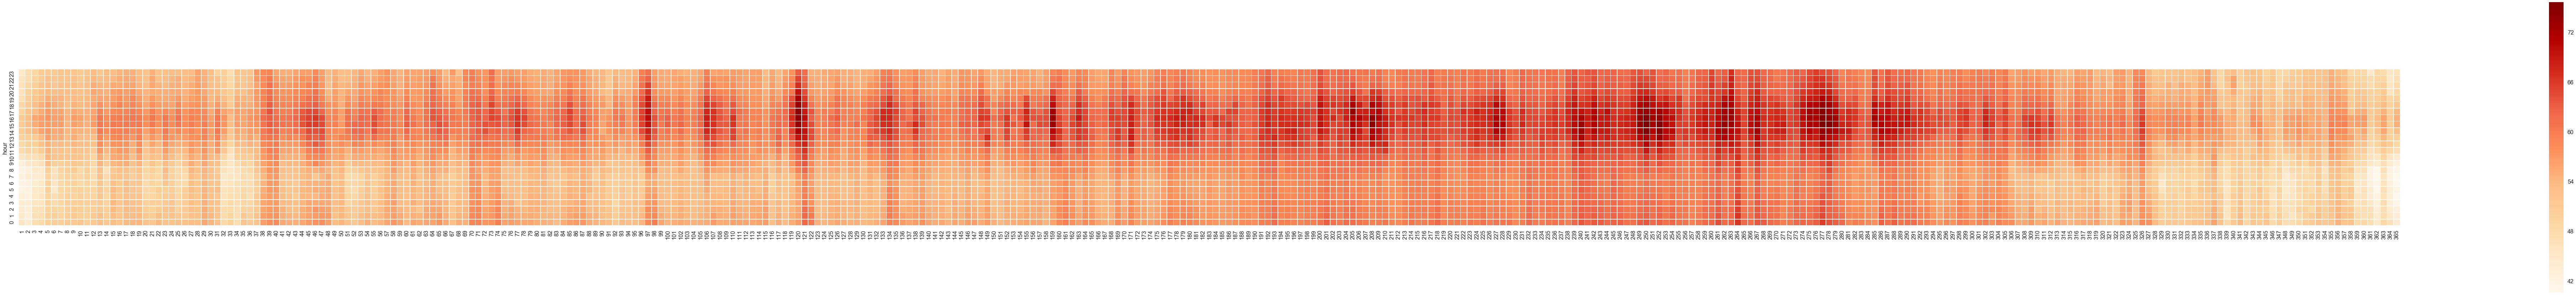

In [782]:
daily_temperature_stats['data']
d = daily_temperature_stats['data'].iloc[:,:-4]

# d = d.transpose()
d = d[::-1]

plt.subplots(figsize=(GRID_DIMS*10, GRID_DIMS))
ax = sns.heatmap(d, square=True, linewidths=.5, cmap='OrRd')
plt.show()
plt.close()

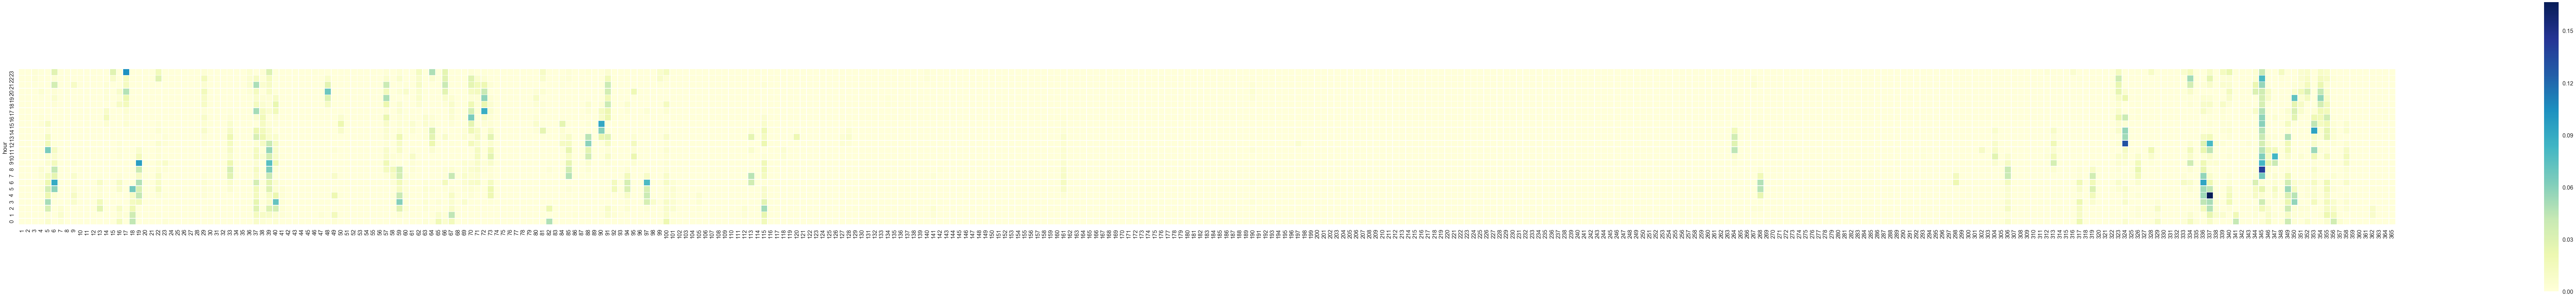

In [783]:
daily_precipitation_stats['data']
d = daily_precipitation_stats['data'].iloc[:,:-4]

# d = d.transpose()
d = d[::-1]

plt.subplots(figsize=(GRID_DIMS*10, GRID_DIMS))
ax = sns.heatmap(d, square=True, linewidths=.5, cmap='YlGnBu')
plt.show()
plt.close()

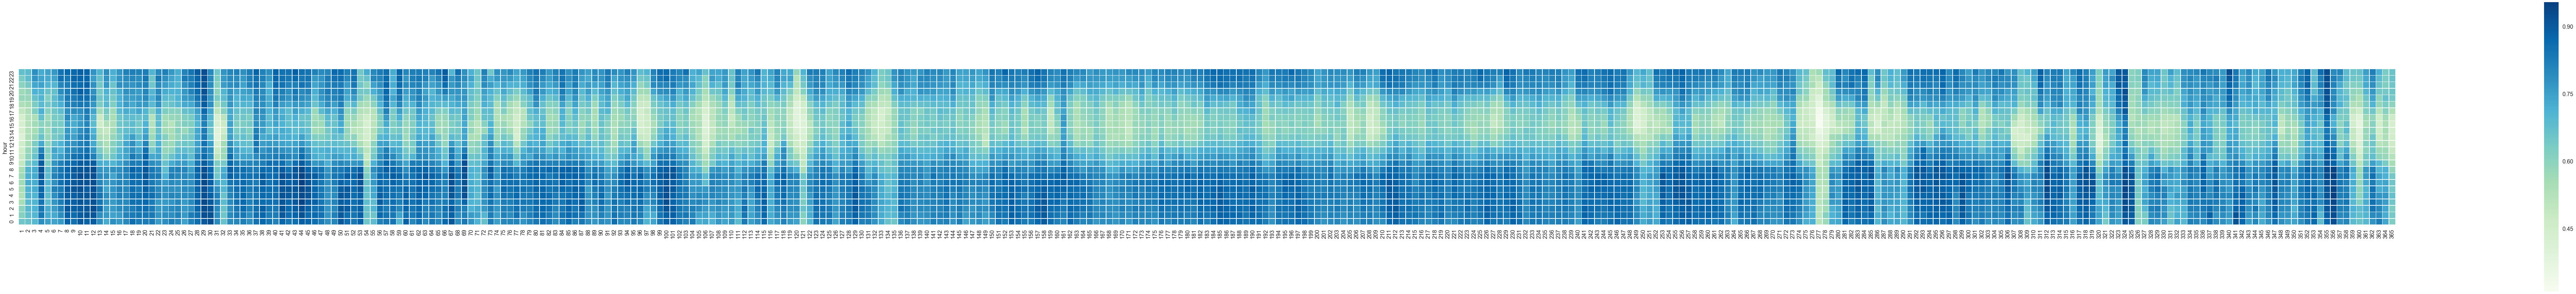

In [784]:
daily_humidity_stats['data']
d = daily_humidity_stats['data'].iloc[:,:-4]

# d = d.transpose()
d = d[::-1]

plt.subplots(figsize=(GRID_DIMS*10, GRID_DIMS))
ax = sns.heatmap(d, square=True, linewidths=.5, cmap='GnBu')
plt.show()
plt.close()

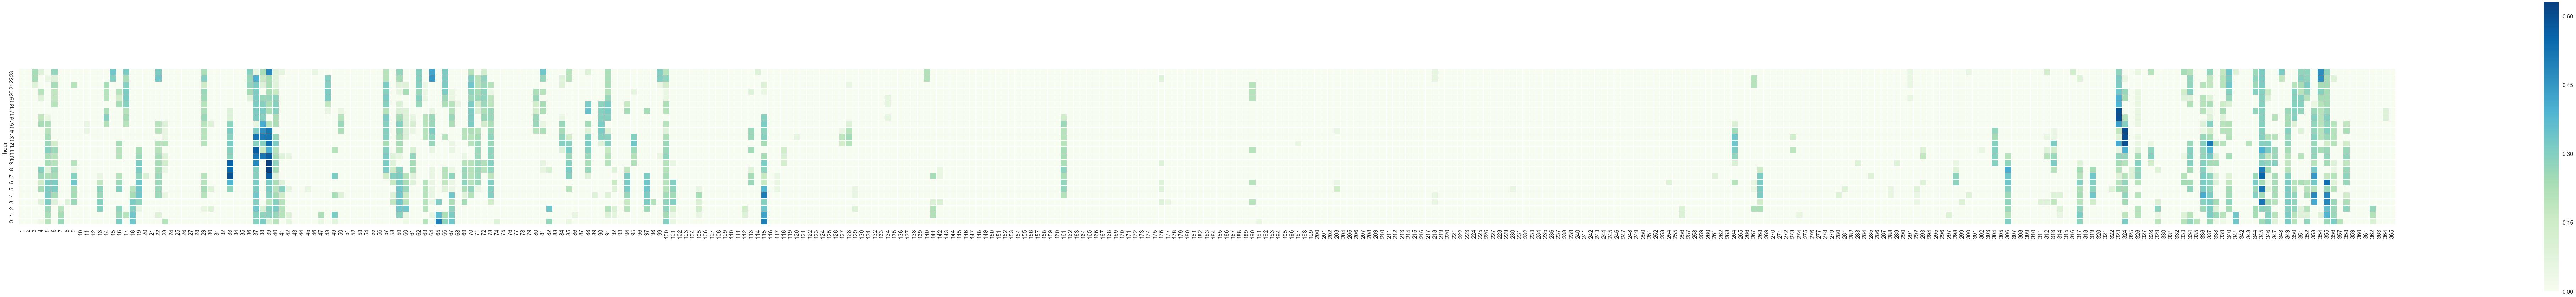

In [785]:
daily_precipprob_stats['data']
d = daily_precipprob_stats['data'].iloc[:,:-4]

# d = d.transpose()
d = d[::-1]

plt.subplots(figsize=(GRID_DIMS*10, GRID_DIMS))
ax = sns.heatmap(d, square=True, linewidths=.5, cmap='GnBu')
plt.show()
plt.close()

# Identify and Tag `Rainy` and `Dry` Commutes
<ul> <b>Rainy Conditions</b> are if any of the following are met at trip start date and time
    <li>Precipitation Intensity is Greater than 0.0</li>
    <li>Precipitation Type is Rain</li>
    <li>Precipitation Probability is Greater than 0.59</li>
</ul>

In [5]:
def tag_rainy_commutes(trip_df=None):
    df = trip_df.copy()
    df['rain_cat'] = 'dry'

    rain_index = df[(df.precipIntensity > 0.0) | 
                                      (df.precipType > 0) | 
                                      (df.precipProbability >= 0.59)].index


    df.iloc[rain_index, list(df.columns).index('rain_cat')] = 'rain'
    
    return df

In [6]:
morning_commutes = tag_rainy_commutes(morning_commutes)
evening_commutes = tag_rainy_commutes(evening_commutes)

# Identify and Tag `Cold`, `Hot` and `Normal` Commutes
<ul>
    <li><b>Cold Conditions</b> are trips starting when the temperature more than one standard deviation below the mean</li>
    <li><b>Hot Conditions</b> are trips starting when the temperature more than one standard deviation above the mean</li>
    <li><b>Normal Conditions</b> are trips starting when the temperature neither `Cold` nor `Hot`</li>
</ul>

In [7]:
def tag_temperature_category(trip_df=None):
    df = trip_df.copy()
    
    hot_cutoff  = df.apparentTemperature.mean() + (1 * df.apparentTemperature.std())
    cold_cutoff = df.apparentTemperature.mean() - (1 * df.apparentTemperature.std())

    df['temp_cat'] = 'Normal'
    hot_index = df[df.apparentTemperature >= hot_cutoff].index
    df.iloc[hot_index,list(df.columns).index('temp_cat')] = 'Hot'

    cold_index = df[df.apparentTemperature <= cold_cutoff].index
    df.iloc[cold_index,list(df.columns).index('temp_cat')] = 'Cold'

    cold_days = df[df.temp_cat == 'Cold'].copy()
    cold_days = len(cold_days.groupby(cold_days.start_date.dt.date).count().index)
    hot_days  = df[df.temp_cat == 'Hot'].copy()
    hot_days = len(hot_days.groupby(hot_days.start_date.dt.date).count().index)
    norm_days = df[df.temp_cat == 'Normal'].copy()
    norm_days = len(norm_days.groupby(norm_days.start_date.dt.date).count().index)

    print('Number of Cold days   {:d}'.format(cold_days))
    print('Number of Hot days    {:d}'.format(hot_days))
    print('Number of Normal days {:d}'.format(norm_days))
    print('')
    print('hot_cutoff    {:3.4f}'.format(hot_cutoff))
    print('cold_cutoff   {:3.4f}'.format(cold_cutoff))
    print('hot trips     {:d}'.format(hot_index.shape[0]))
    print('cold trips    {:d}'.format(cold_index.shape[0]))
    print('normal trips  {:d}'.format(df[df.temp_cat == 'Normal'].shape[0]))
    
    return df

In [8]:
morning_commutes = tag_temperature_category(trip_df=morning_commutes)

Number of Cold days   174
Number of Hot days    179
Number of Normal days 640

hot_cutoff    61.1770
cold_cutoff   51.1148
hot trips     15348
cold trips    12158
normal trips  72352


In [9]:
evening_commutes = tag_temperature_category(trip_df=evening_commutes)

Number of Cold days   212
Number of Hot days    161
Number of Normal days 634

hot_cutoff    68.8091
cold_cutoff   57.1720
hot trips     13276
cold trips    14214
normal trips  72440


# RankSum and Two Sample T Tests

In [395]:
from scipy.stats import ranksums
from scipy.stats import ttest_ind

In [396]:
def ranksums_test(dfA, dfB, a_label='', b_label=''):
    
    if dfA.shape[0] > 0:
        A_mean = dfA.mean()
    else:
        A_mean = 0

    if dfB.shape[0] > 0:
        B_mean = dfB.mean()
    else:
        B_mean = 0

    diff_of_means = A_mean - B_mean
    
    if A_mean > 0 or B_mean > 0:
        # perform ranksums test
        z, z_p = ranksums(dfA, dfB)
        t, t_p = ttest_ind(dfA, dfB)
        drop_share = diff_of_means / A_mean * 100.
        
    else:
        z, z_p = [0, 0]
        t, t_p = [0, 0]
        drop_share = 0


    z_can_reject = False
    t_can_reject = False

    if z_p <= 0.05:
        z_can_reject = True
    if t_p <= 0.05:
        t_can_reject = True
        
    results = {'z_score':z, 
                'z_p_value':z_p,
                't_score':t, 
                't_p_value':t_p,
                '{}_intervals'.format(a_label):dfA.shape[0], 
                '{}_intervals'.format(b_label):dfB.shape[0], 
                '{}_mean'.format(a_label):A_mean, 
                '{}_mean'.format(b_label):B_mean, 
                'diff_of_means':diff_of_means, 
                'drop_share':drop_share,
                'z_can_reject':z_can_reject,
                't_can_reject':t_can_reject}
    
    return results
    

# Plot P Values of Z and T Tests

In [397]:
def plot_p_values(df=None, c1=sub_color, c2=sub_color_alt, title='Rainy Morning Commute P-Value', legend_loc=1, hour_range=[7, 10]):

    alpha=0.35
    plt.subplots(figsize=FIG_SIZE)
    ax = sns.barplot(x=df.index, y=df.z_p_value, color=c1, alpha=alpha, label='Wilcoxon Rank-Sum Statistic')

    sns.barplot(x=df.index, y=df.t_p_value, color=c2, alpha=alpha, ax=ax, label='Two Sample T Test')

    ax.axhline(y=0.05, linestyle='-.', alpha=1.0, color='k', linewidth=3)


    x_tick_interval = df.shape[0]/len(day_labels[:5])    
    for x in np.arange(0, x_tick_interval+1):
        ax.axvline(x=x*x_tick_interval+x_tick_interval*(5/6), linestyle=':', alpha=0.5, color='k', linewidth=3)

    x_tick_labels = []
    for x in range(0, df.shape[0]+1, 1):
        label = '{} {}:00'.format(day_labels[int(x/3)], math.floor(x/3)+hour_range[0])
        x_tick_labels.append(label)
        
    # print(x_ticks)
    ax.set_xticks([x-0.5 for x in range(0, df.shape[0], 1)])
    ax.set_xticklabels(x_tick_labels, rotation=45)
    
    ax.set_ylabel('p value')
    ax.set_ylim([0, 0.2])

    ax.legend(loc=legend_loc, frameon=True)

    ax.set_title(title, size=TITLE_FONT_SIZE)
    plt.show()
    save_path = '../charts/statistical_analysis/{}.png'.format(title.lower().replace(' ', '_').replace('-', ''))
    print(save_path)
    # plt.savefig(save_path)
    plt.close()

# Impact of Rain on Commuter Trip Counts


<div class="alert alert-info">

<p><b>1a. Morning Commutes</b></p>

<p>A <b>Wilcoxon Rank-Sum Statistic Test</b> is appropriate for this problem as we are trying to see a difference between two sample means from data sets with very different values.</p>

<ul>
    <li>$H$o : Morning Commuter Mean Number of trips on Rainy Days = Morning Commuter Mean Number of trips on Dry Days</li>
    <li>$H$a : Morning Commuter Mean Number of trips on Rainy Days ≠ Morning Commuter Mean Number of trips on Dry Days</li>
</ul>
</div>

In [398]:
def rain_test(trip_df=None, hour_range=[7,10]):
    chunks = []
    
    for dayofweek in sorted(trip_df.start_date.dt.dayofweek.unique()):
        if dayofweek < 5:
            for hour in range(hour_range[0], hour_range[1], 1):
                trips = trip_df[(trip_df.start_date.dt.hour == hour) & (trip_df.start_date.dt.dayofweek == dayofweek)].copy()

                RAINY = trips[trips['rain_cat'] == 'rain']
                sum_rain = RAINY.groupby([RAINY.start_date.dt.date])['precipIntensity'].sum().sum()
                RAINY = RAINY.groupby([RAINY.start_date.dt.date])['trip_id'].count()

                DRY   = trips[trips['rain_cat'] == 'dry']
                DRY = DRY.groupby([DRY.start_date.dt.date])['trip_id'].count()

                R = ranksums_test(DRY, RAINY, a_label='dry', b_label='wet')
                R['dayofweek'] = dayofweek
                R['hour'] = hour
                R['sum_rain'] = sum_rain

                chunks.append(R)

    result = pd.DataFrame(chunks)
    result['total_intervals'] = result.dry_intervals + result.wet_intervals
    result.fillna(0, inplace=True)
    
    result.drop_share = result.drop_share.apply(lambda x: 0.0 if x == 100 else x)
    
    return result

Morning


/Users/samgutentag/anaconda/envs/spring/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3146: RuntimeWarning: Degrees of freedom <= 0 for slice
  **kwargs)
/Users/samgutentag/anaconda/envs/spring/lib/python3.6/site-packages/numpy/core/_methods.py:127: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/Users/samgutentag/anaconda/envs/spring/lib/python3.6/site-packages/scipy/stats/stats.py:4956: RuntimeWarning: invalid value encountered in double_scalars
  z = (s - expected) / np.sqrt(n1*n2*(n1+n2+1)/12.0)


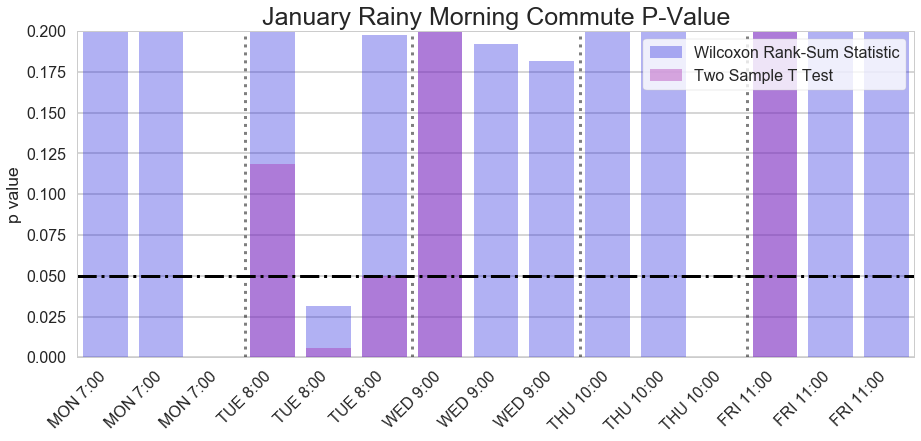

../charts/statistical_analysis/january_rainy_morning_commute_pvalue.png


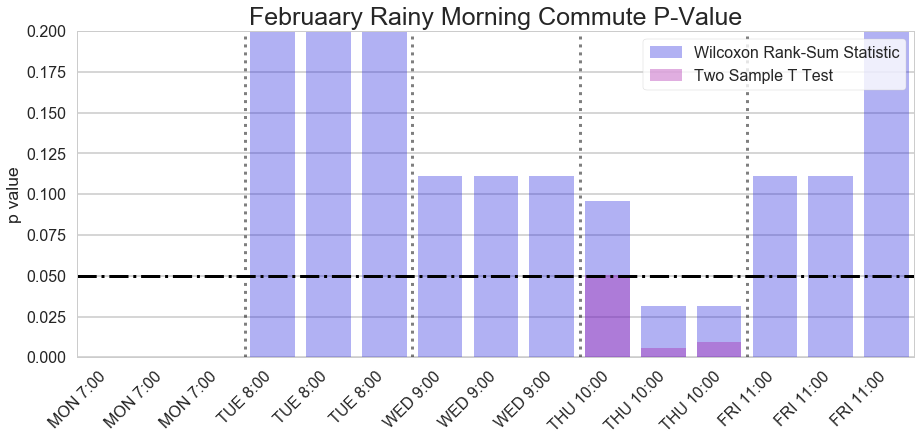

../charts/statistical_analysis/februaary_rainy_morning_commute_pvalue.png


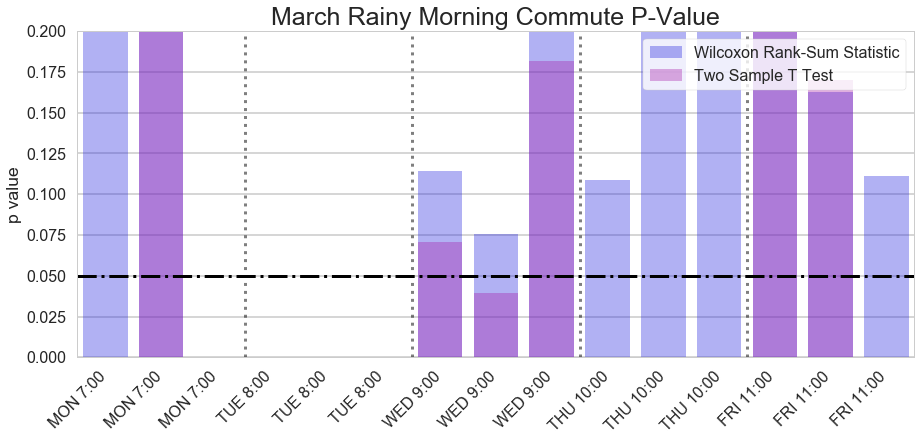

../charts/statistical_analysis/march_rainy_morning_commute_pvalue.png


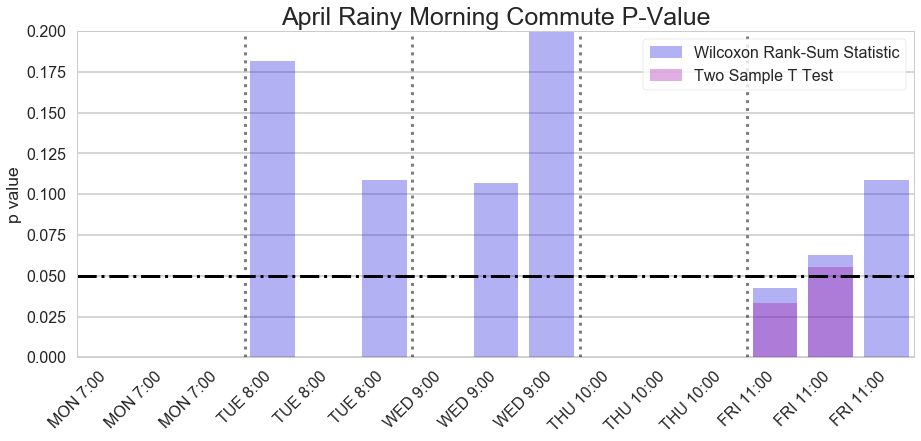

../charts/statistical_analysis/april_rainy_morning_commute_pvalue.png


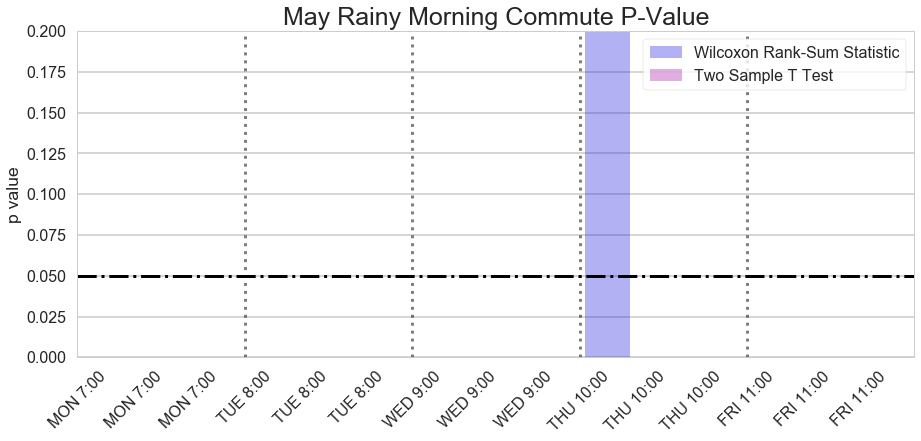

../charts/statistical_analysis/may_rainy_morning_commute_pvalue.png


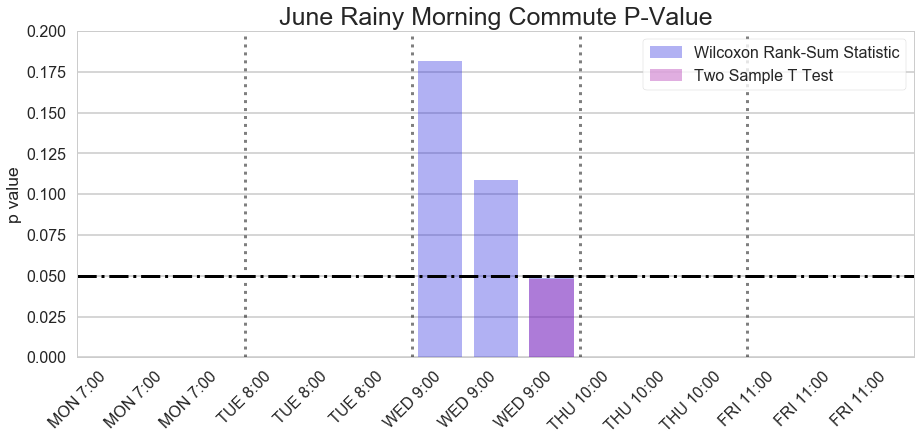

../charts/statistical_analysis/june_rainy_morning_commute_pvalue.png


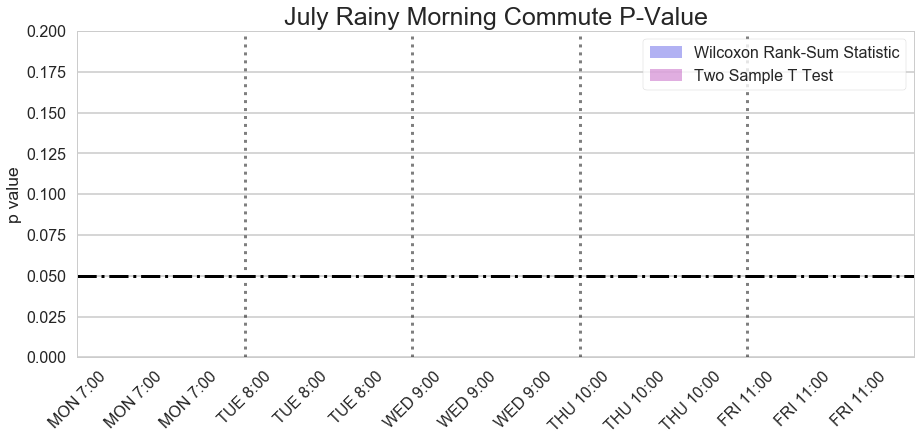

../charts/statistical_analysis/july_rainy_morning_commute_pvalue.png


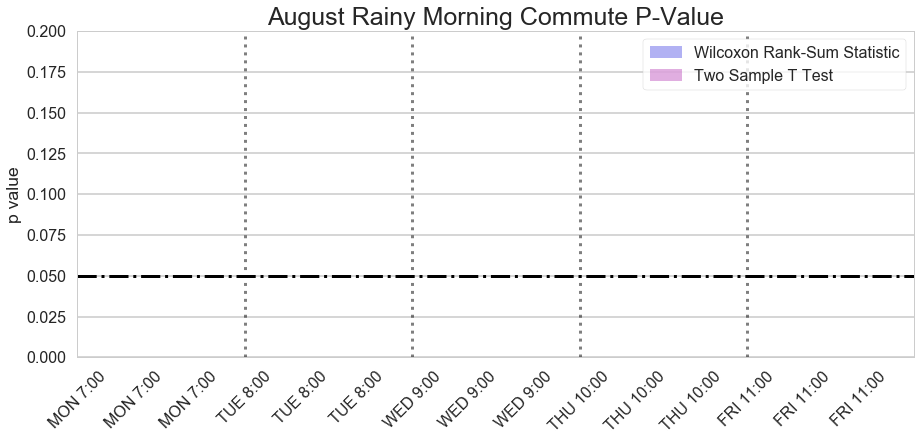

../charts/statistical_analysis/august_rainy_morning_commute_pvalue.png


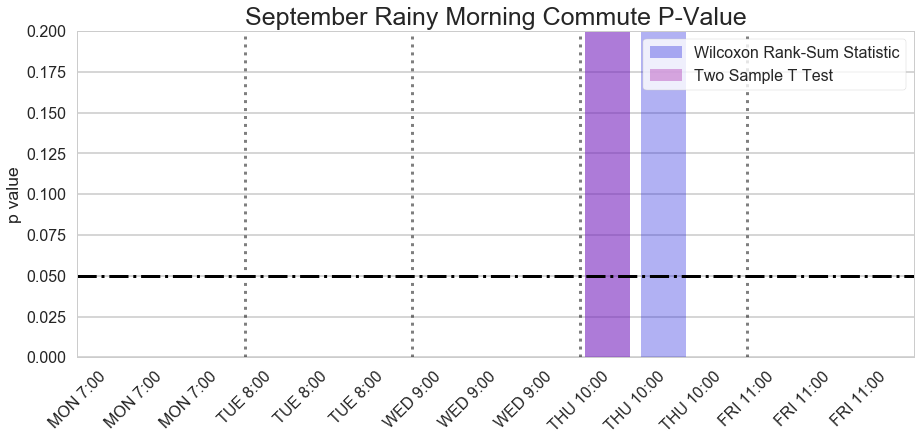

../charts/statistical_analysis/september_rainy_morning_commute_pvalue.png


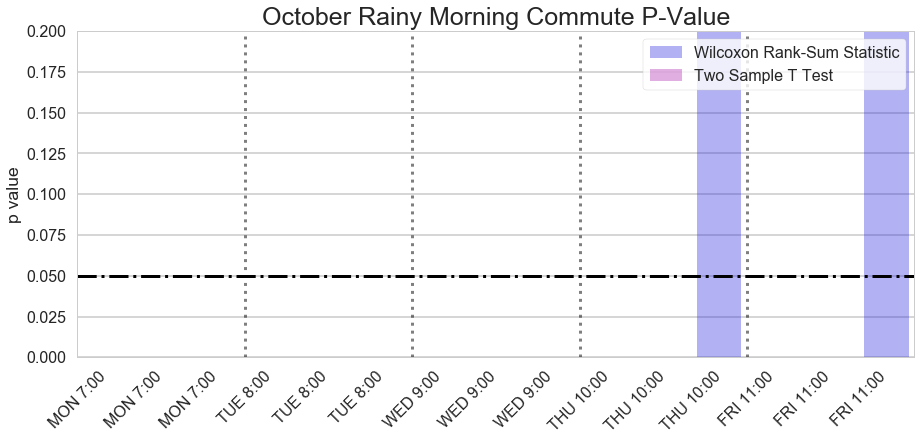

../charts/statistical_analysis/october_rainy_morning_commute_pvalue.png


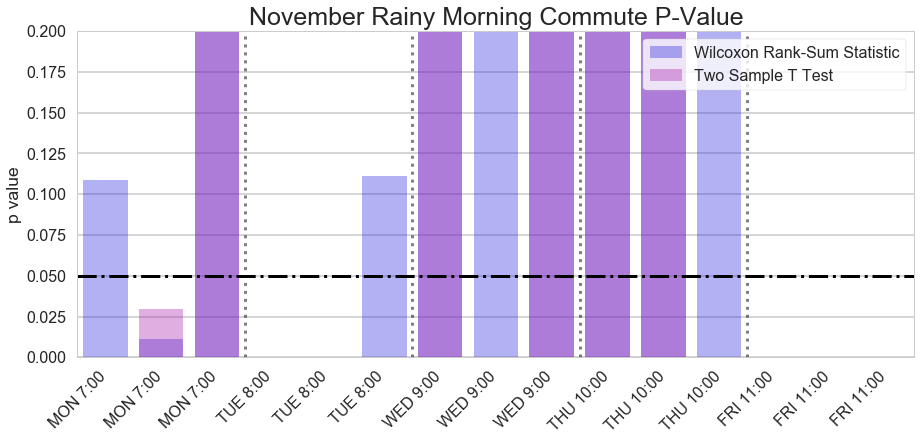

../charts/statistical_analysis/november_rainy_morning_commute_pvalue.png


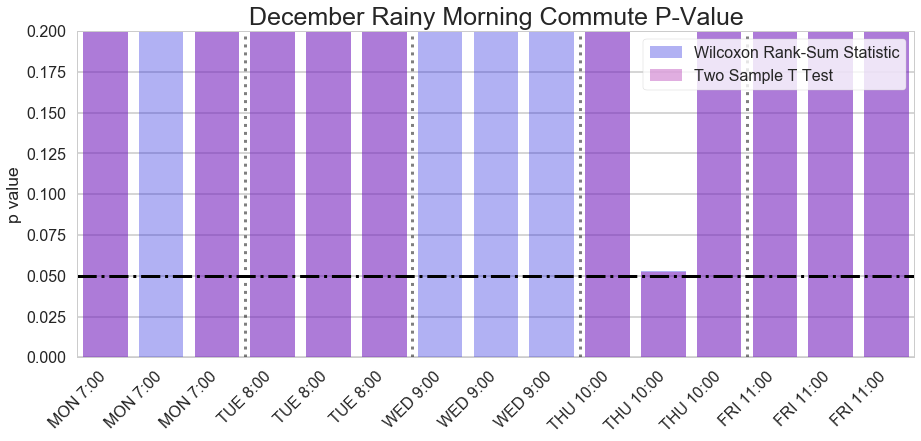

../charts/statistical_analysis/december_rainy_morning_commute_pvalue.png
Evening


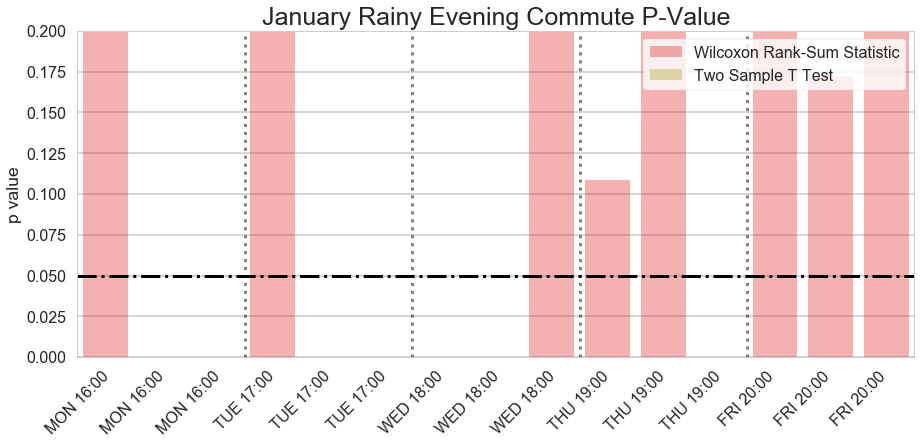

../charts/statistical_analysis/january_rainy_evening_commute_pvalue.png


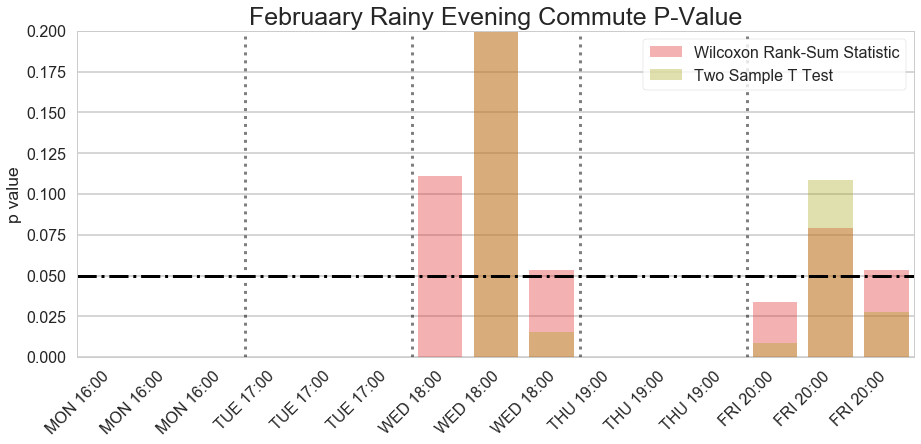

../charts/statistical_analysis/februaary_rainy_evening_commute_pvalue.png


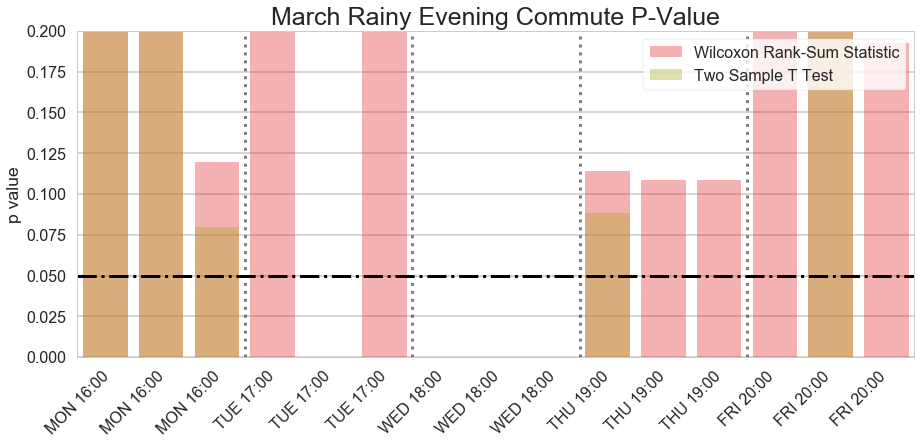

../charts/statistical_analysis/march_rainy_evening_commute_pvalue.png


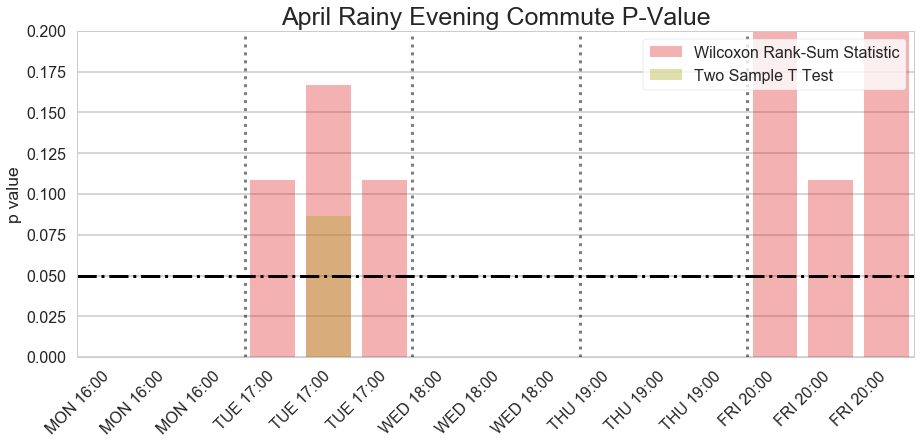

../charts/statistical_analysis/april_rainy_evening_commute_pvalue.png


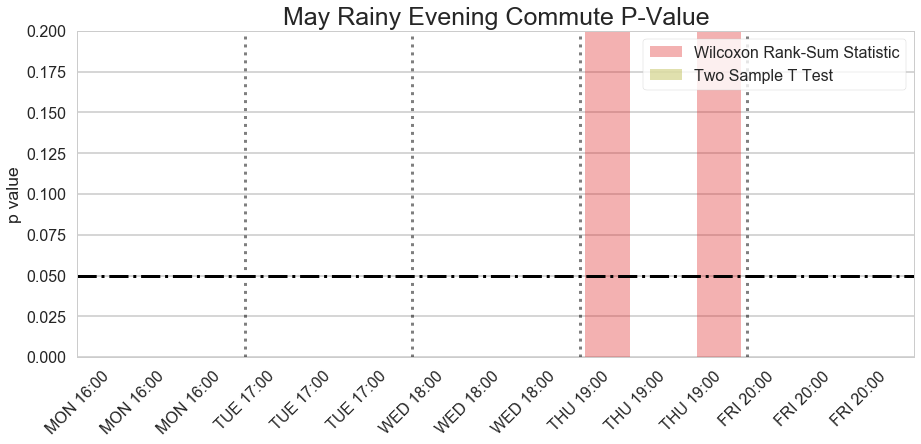

../charts/statistical_analysis/may_rainy_evening_commute_pvalue.png


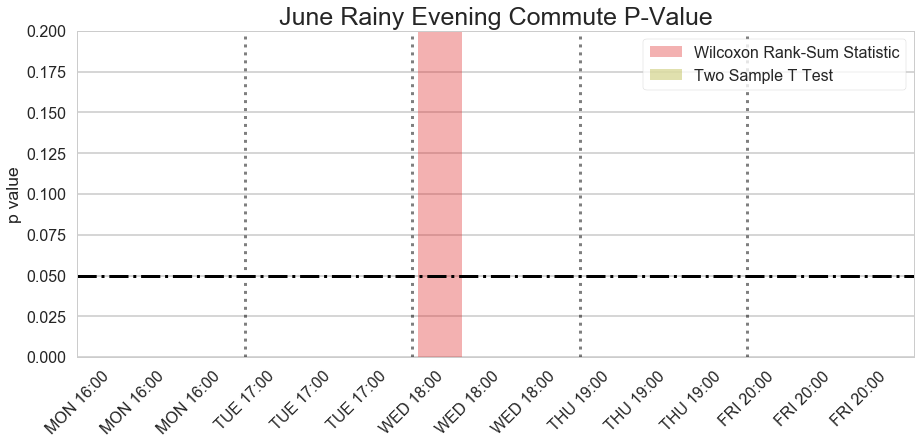

../charts/statistical_analysis/june_rainy_evening_commute_pvalue.png


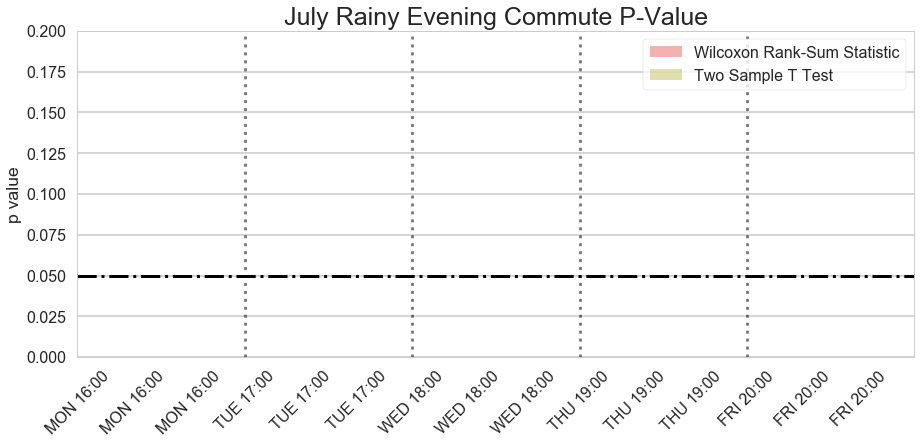

../charts/statistical_analysis/july_rainy_evening_commute_pvalue.png


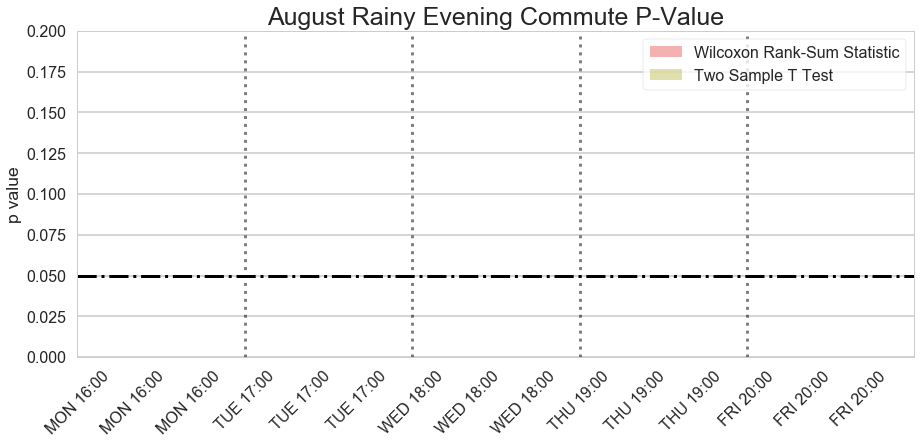

../charts/statistical_analysis/august_rainy_evening_commute_pvalue.png


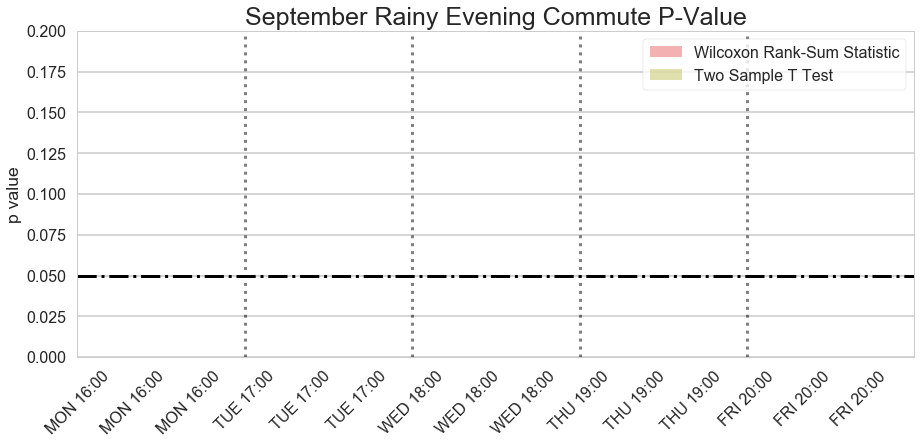

../charts/statistical_analysis/september_rainy_evening_commute_pvalue.png


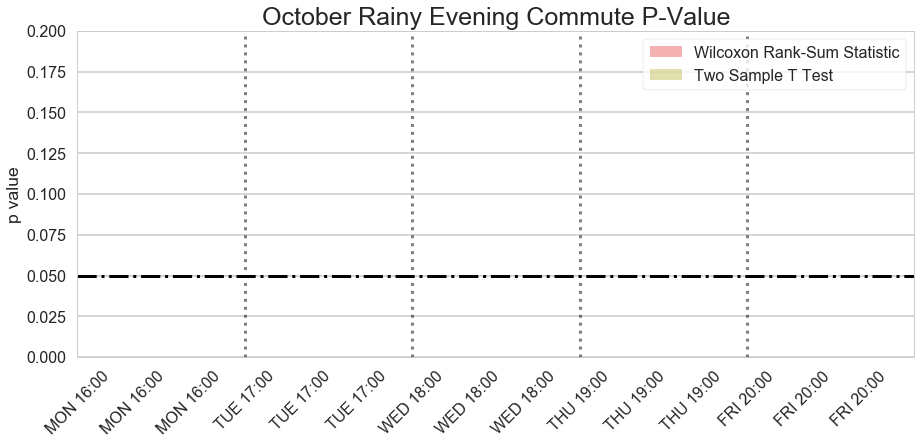

../charts/statistical_analysis/october_rainy_evening_commute_pvalue.png


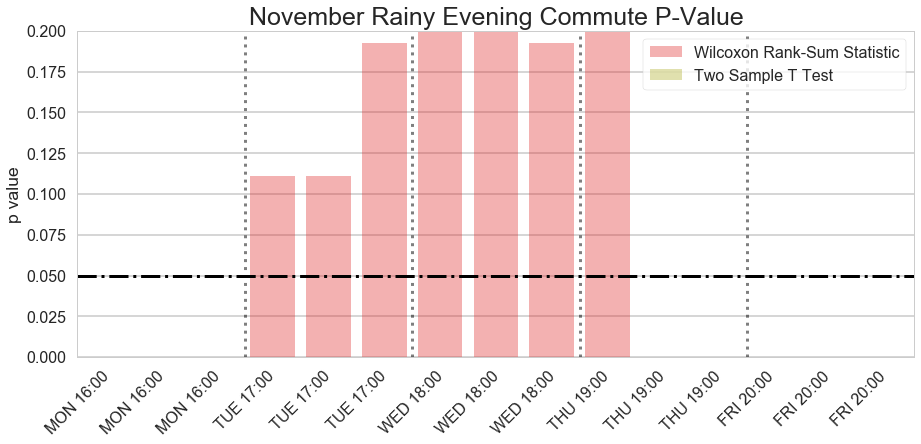

../charts/statistical_analysis/november_rainy_evening_commute_pvalue.png


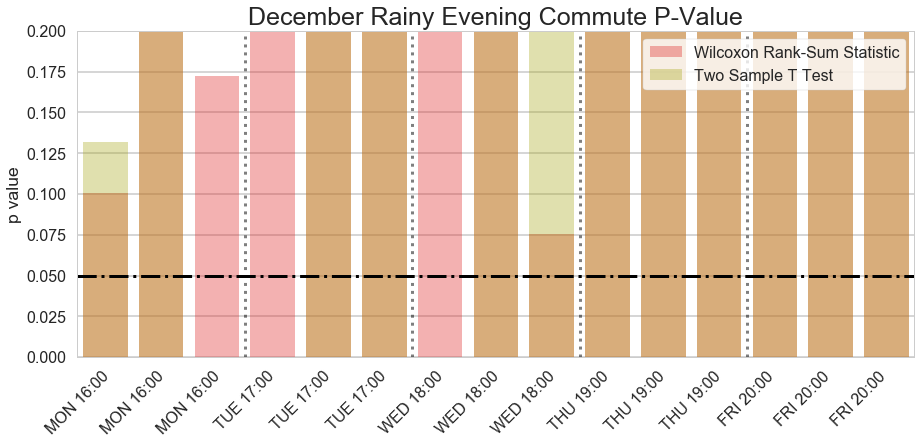

../charts/statistical_analysis/december_rainy_evening_commute_pvalue.png


In [404]:
print('Morning')
morning_results = {}
for month in sorted(morning_commutes.start_date.dt.month.unique()):    
    month_result_key = month_labels_full[month-1].title()
    trips = morning_commutes[morning_commutes.start_date.dt.month == month].copy()
    test_results = rain_test(trip_df=trips, hour_range=[7,10])
    morning_results[month_result_key] = test_results
    plot_p_values(df=test_results, c1=sub_color, c2=sub_color_alt, title='{} Rainy Morning Commute P-Value'.format(month_result_key), legend_loc=1, hour_range=[7, 10])


print('Evening')    
evening_results = {}
for month in sorted(evening_commutes.start_date.dt.month.unique()):    
    month_result_key = month_labels_full[month-1].title()
    trips = evening_commutes[evening_commutes.start_date.dt.month == month].copy()
    test_results = rain_test(trip_df=trips, hour_range=[16,19])
    evening_results[month_result_key] = test_results
    plot_p_values(df=test_results, c1=cust_color, c2=cust_color_alt, title='{} Rainy Evening Commute P-Value'.format(month_result_key), legend_loc=1, hour_range=[16, 19])

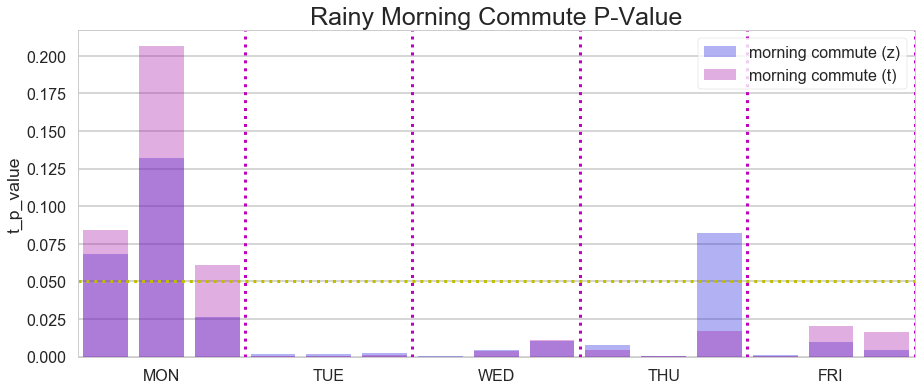

In [241]:
alpha=0.35
plt.subplots(figsize=FIG_SIZE)
ax = sns.barplot(x=morning_commute_t_test.index, y=morning_commute_t_test.z_p_value, color=sub_color, alpha=alpha, label='morning commute (z)')

sns.barplot(x=morning_commute_t_test.index, y=morning_commute_t_test.t_p_value, color=sub_color_alt, alpha=alpha, ax=ax, label='morning commute (t)')

ax.axhline(y=0.05, linestyle=':', alpha=1.0, color='y', linewidth=3)

x_ticks = []
x_tick_interval = morning_commute_t_test.shape[0]/len(day_labels[:5])
for x in np.arange(0, morning_commute_t_test.shape[0], x_tick_interval):
    x_ticks.append(x+(x_tick_interval/3))
    ax.axvline(x=x+x_tick_interval-(x_tick_interval/6), linestyle=':', alpha=1.0, color=sub_color_alt, linewidth=3)

# print(x_ticks)
ax.set_xticks(x_ticks)
ax.set_xticklabels(day_labels[:5])

ax.legend(loc=1, frameon=True)

title = 'Rainy Morning Commute P-Value'
ax.set_title(title, size=TITLE_FONT_SIZE)
plt.show()
# save_path = '../charts/statistical_analysis/01_%s.png' % title.lower().replace(' ', '_')
# plt.savefig(save_path)
plt.close()

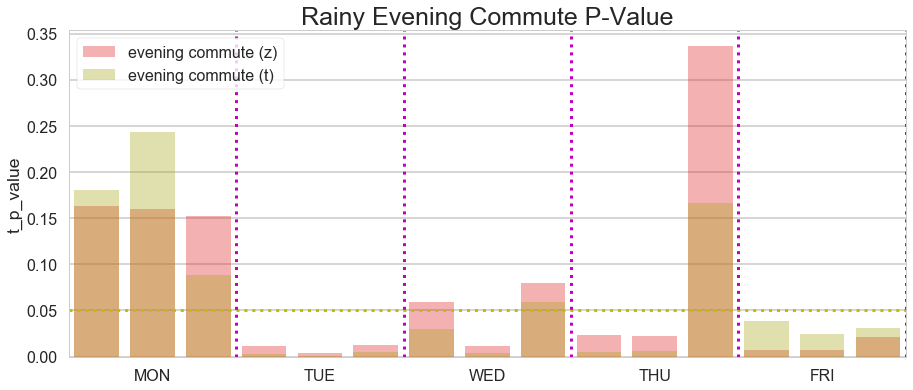

In [243]:
alpha=0.35
plt.subplots(figsize=FIG_SIZE)
ax = sns.barplot(x=evening_commute_t_test.index, y=evening_commute_t_test.z_p_value, color=cust_color, alpha=alpha, label='evening commute (z)')

sns.barplot(x=evening_commute_t_test.index, y=evening_commute_t_test.t_p_value, color=cust_color_alt, alpha=alpha, ax=ax, label='evening commute (t)')

ax.axhline(y=0.05, linestyle=':', alpha=1.0, color='y', linewidth=3)

x_ticks = []
x_tick_interval = evening_commute_t_test.shape[0]/len(day_labels[:5])
for x in np.arange(0, evening_commute_t_test.shape[0], x_tick_interval):
    x_ticks.append(x+(x_tick_interval/3))
    ax.axvline(x=x+x_tick_interval-(x_tick_interval/6), linestyle=':', alpha=1.0, color=sub_color_alt, linewidth=3)

# print(x_ticks)
ax.set_xticks(x_ticks)
ax.set_xticklabels(day_labels[:5])

ax.legend(loc=2, frameon=True)

title = 'Rainy Evening Commute P-Value'
ax.set_title(title, size=TITLE_FONT_SIZE)
plt.show()
# save_path = '../charts/statistical_analysis/01_%s.png' % title.lower().replace(' ', '_')
# plt.savefig(save_path)
plt.close()

In [222]:
morning_commute_t_test.drop_share.describe()

count    15.000000
mean     34.719555
std       8.839739
min      18.766850
25%      26.988780
50%      35.042735
75%      41.437730
max      50.594210
Name: drop_share, dtype: float64

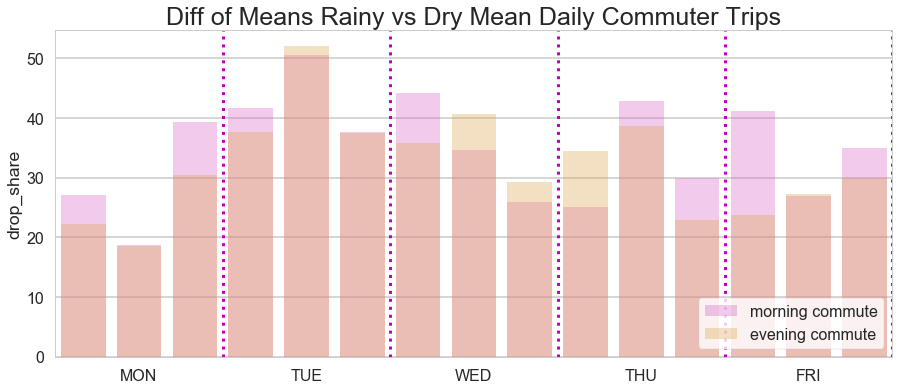

In [224]:
plt.subplots(figsize=FIG_SIZE)
ax = sns.barplot(x=morning_commute_t_test.index, y=morning_commute_t_test.drop_share, color=commuter_am, alpha=0.35, label='morning commute')
sns.barplot(x=evening_commute_t_test.index, y=evening_commute_t_test.drop_share, color=commuter_pm_alt, alpha=0.35, ax=ax, label='evening commute')

x_ticks = []
x_tick_interval = morning_commute_t_test.shape[0]/len(day_labels[:5])
for x in np.arange(0, morning_commute_t_test.shape[0], x_tick_interval):
    x_ticks.append(x+(x_tick_interval/3))
    ax.axvline(x=x+x_tick_interval-(x_tick_interval/6), linestyle=':', alpha=1.0, color=sub_color_alt, linewidth=3)

# print(x_ticks)
ax.set_xticks(x_ticks)
ax.set_xticklabels(day_labels[:5])
ax.legend(loc=4, frameon=True)

title = 'Diff of Means Rainy vs Dry Mean Daily Commuter Trips'
ax.set_title(title, size=TITLE_FONT_SIZE)
plt.show()
# save_path = '../charts/statistical_analysis/01_%s.png' % title.lower().replace(' ', '_')
# plt.savefig(save_path)
plt.close()


<div class="alert alert-info">

<p><b>1b. Evening Commutes</b></p>

<p>A <b>Wilcoxon Rank-Sum Statistic Test</b> is appropriate for this problem as we are trying to see a difference between two sample means from data sets with very different values.</p>


<ul>
    <li>$H$o : Evening Commuter Mean Number of trips on Rainy Days = Evening Commuter Mean Number of trips on Dry Days</li>
    <li>$H$a : Evening Commuter Mean Number of trips on Rainy Days ≠ Evening Commuter Mean Number of trips on Dry Days</li>
</ul>
</div>

In [ ]:
chunks = []

for month in sorted(evening_commutes.start_date.dt.month.unique()):
#     print('\nMonth of %s' % month_labels[month-1])

    month_trips = evening_commutes[evening_commutes.start_date.dt.month == month].copy()

    # Morning Commutes
    evening_RAINY = month_trips[month_trips['rain_cat'] == 'rain']
    evening_RAINY = evening_RAINY.groupby([evening_RAINY.start_date.dt.date])['trip_id'].count()

    evening_DRY   = month_trips[month_trips['rain_cat'] == 'dry']
    evening_DRY = evening_DRY.groupby([evening_DRY.start_date.dt.date])['trip_id'].count()
        
    R = ranksums_test(evening_DRY, evening_RAINY, a_label='dry', b_label='wet')
    chunks.append(R)
#     print('-' * 60)
    
evening_commute_t_test = pd.DataFrame(chunks)
evening_commute_t_test['month'] = month_labels

evening_commute_t_test.fillna(0, inplace=True)
evening_commute_t_test

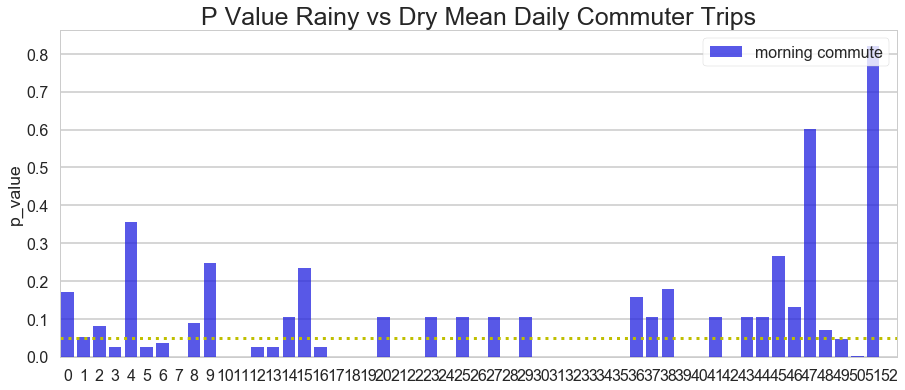

In [66]:
plt.subplots(figsize=FIG_SIZE)
ax = sns.barplot(x=morning_commute_t_test.index, y=morning_commute_t_test.p_value, color=sub_color, alpha=0.75, label='morning commute')
# sns.barplot(x=evening_commute_t_test.index, y=evening_commute_t_test.p_value, color=cust_color, alpha=0.75, ax=ax, label='evening commute')

ax.axhline(y=0.05, linestyle=':', alpha=1.0, color='y', linewidth=3)

ax.set_xticks(morning_commute_t_test.index, month_labels)
ax.legend(loc=1, frameon=True)

title = 'P Value Rainy vs Dry Mean Daily Commuter Trips'
ax.set_title(title, size=TITLE_FONT_SIZE)
plt.show()
# save_path = '../charts/statistical_analysis/01_%s.png' % title.lower().replace(' ', '_')
# plt.savefig(save_path)
plt.close()

In [ ]:
print('morning drop share {:3.4f}'.format(morning_commute_t_test[['drop_share']].mean()[0]))
print('evening drop share {:3.4f}'.format(evening_commute_t_test[['drop_share']].mean()[0]))

NameError: name 'evening_commute_t_test' is not defined

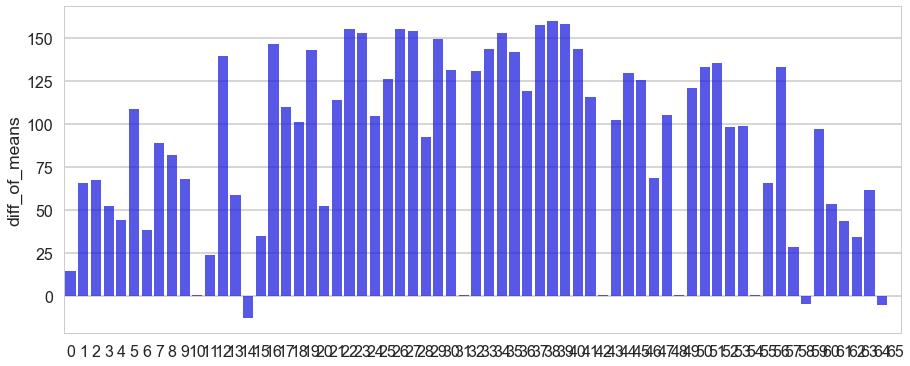

In [16]:
plt.subplots(figsize=FIG_SIZE)
ax = sns.barplot(x=morning_commute_t_test.index, y=morning_commute_t_test.diff_of_means, color=sub_color, alpha=0.75, label='morning commute')
sns.barplot(x=evening_commute_t_test.index, y=evening_commute_t_test.diff_of_means, color=cust_color, alpha=0.75, ax=ax, label='evening commute')

# ax.set_xticks(morning_commute_t_test.index, month_labels)
ax.legend(loc=1, frameon=True)

# ax.set_yticks([x for x in range(0, 120, 20)])

title = 'Drop Ratio of Mean Daily Commuter Trips in Rainy Conditions'
ax.set_title(title, size=TITLE_FONT_SIZE)
plt.show()
# save_path = '../charts/statistical_analysis/01_%s.png' % title.lower().replace(' ', '_')
# plt.savefig(save_path)
plt.close()

# Impact of Temperature on Commuter Trip Counts


<div class="alert alert-info">

<p><b>2a. Morning Commutes</b></p>

<p>A <b>Wilcoxon Rank-Sum Statistic Test</b> is appropriate for this problem as we are trying to see a difference between two sample means from data sets with very different values.</p>

<ul>
    <li>$H$o : Morning Commuter Mean Number of trips on Cold Days = Morning Commuter Mean Number of trips on Normal Days</li>
    <li>$H$a : Morning Commuter Mean Number of trips on Cold Days ≠ Morning Commuter Mean Number of trips on Normal Days</li>
</ul>

<ul>
    <li>$H$o : Morning Commuter Mean Number of trips on Hot Days = Morning Commuter Mean Number of trips on Normal Days</li>
    <li>$H$a : Morning Commuter Mean Number of trips on Hot Days ≠ Morning Commuter Mean Number of trips on Normal Days</li>
</ul>
</div>

In [ ]:
# Morning Commutes
m_COLD = morning_commutes[morning_commutes['temp_cat'] == 'Cold']
m_COLD = m_COLD.groupby(m_COLD.start_date.dt.date)['trip_id'].count()

m_NORM = morning_commutes[morning_commutes['temp_cat'] == 'Normal']
m_NORM = m_NORM.groupby(m_NORM.start_date.dt.date)['trip_id'].count()

m_HOT = morning_commutes[morning_commutes['temp_cat'] == 'Hot']
m_HOT = m_HOT.groupby(m_HOT.start_date.dt.date)['trip_id'].count()

In [ ]:
chunks = []

for month in sorted(morning_commutes.start_date.dt.month.unique()):
    print('\nMonth of %s' % month_labels[month-1])

    month_data = morning_commutes[morning_commutes.start_date.dt.month == month].copy()

    # Morning Commutes
    m_HOT = month_data[month_data['temp_cat'] == 'Hot']
    m_HOT = m_HOT.groupby([m_HOT.start_date.dt.date])['trip_id'].count()

    m_NORMAL   = month_data[month_data['temp_cat'] == 'Normal']
    m_NORMAL = m_NORMAL.groupby([m_NORMAL.start_date.dt.date])['trip_id'].count()
        
    R = ranksums_test(m_NORMAL, m_HOT, a_label='Normal', b_label='Hot')
    chunks.append(R)
    print('-' * 60)

In [ ]:
morning_hot_commute_t_test = pd.DataFrame(chunks)
morning_hot_commute_t_test['month'] = month_labels
morning_hot_commute_t_test.fillna(0, inplace=True)
morning_hot_commute_t_test

In [ ]:
morning_hot_commute_t_test[['p_value']].plot(kind='bar', figsize=(18,6), color='r')
plt.axhline(y=0.05, xmin=-10, xmax=12, hold=None)
plt.ylim([0, 0.1])
plt.xticks(morning_hot_commute_t_test.index, month_labels)
title = 'P Value Normal vs Hot Mean Daily Morning Commuter Trips'
plt.title(title, size=TITLE_FONT_SIZE)
plt.legend('')
plt.show()
plt.close()
# save_path = '../charts/statistical_analysis/02_%s.png' % title.lower().replace(' ', '_')
# plt.savefig(save_path)

In [ ]:
chunks = []

for month in sorted(morning_commutes.start_date.dt.month.unique()):
    print('\nMonth of %s' % month_labels[month-1])

    month_data = morning_commutes[morning_commutes.start_date.dt.month == month].copy()

    # Morning Commutes
    m_COLD = month_data[month_data['temp_cat'] == 'Cold']
    m_COLD = m_COLD.groupby([m_COLD.start_date.dt.date])['trip_id'].count()

    m_NORMAL   = month_data[month_data['temp_cat'] == 'Normal']
    m_NORMAL = m_NORMAL.groupby([m_NORMAL.start_date.dt.date])['trip_id'].count()
        
    R = ranksums_test(m_NORMAL, m_COLD, a_label='Normal', b_label='Cold')
    chunks.append(R)
    print('-' * 60)

In [ ]:
morning_cold_commute_t_test = pd.DataFrame(chunks)
morning_cold_commute_t_test['month'] = month_labels
morning_cold_commute_t_test.fillna(0, inplace=True)
morning_cold_commute_t_test

In [ ]:
morning_cold_commute_t_test[['p_value']].plot(kind='bar', figsize=(18,6), color='b')
plt.axhline(y=0.05, xmin=-10, xmax=12, hold=None)
plt.ylim([0, 0.1])
plt.xticks(morning_cold_commute_t_test.index, month_labels)
title = 'P Value Normal vs Cold Mean Daily Morning Commuter Trips'
plt.title(title, size=TITLE_FONT_SIZE)
plt.legend('')
plt.show()
plt.close()
# save_path = '../charts/statistical_analysis/02_%s.png' % title.lower().replace(' ', '_')
# plt.savefig(save_path)

In [ ]:
morning_cold_commute_t_test[['drop_share']].plot(kind='bar', figsize=(18,6), color='b')
# plt.axhline(y=0.05, xmin=-10, xmax=12, hold=None)
plt.xticks(morning_cold_commute_t_test.index, month_labels)
title = 'Drop Ratio of Mean Daily Morning Commuter Trips in Cold Conditions'
plt.title(title, size=TITLE_FONT_SIZE)
plt.legend('', loc=1, frameon=True)
plt.show()
plt.close()
# save_path = '../charts/statistical_analysis/02_%s.png' % title.lower().replace(' ', '_')
# plt.savefig(save_path)

morning_hot_commute_t_test[['drop_share']].plot(kind='bar', figsize=(18,6), color='r')
# plt.axhline(y=0.05, xmin=-10, xmax=12, hold=None)
plt.xticks(morning_hot_commute_t_test.index, month_labels)
title = 'Drop Ratio of Mean Daily Morning Commuter Trips in Hot Conditions'
plt.title(title, size=TITLE_FONT_SIZE)
plt.legend('', loc=1, frameon=True)
plt.show()
plt.close()
# save_path = '../charts/statistical_analysis/02_%s.png' % title.lower().replace(' ', '_')
# plt.savefig(save_path)


<div class="alert alert-info">

<p><b>2b. Evening Commutes</b></p>


<p>A <b>Wilcoxon Rank-Sum Statistic Test</b> is appropriate for this problem as we are trying to see a difference between two sample means from data sets with very different values.</p>


<ul>
    <li>$H$o : Evening Commuter Mean Number of trips on Cold Days = Evening Commuter Mean Number of trips on Normal Days</li>
    <li>$H$a : Evening Commuter Mean Number of trips on Cold Days ≠ Evening Commuter Mean Number of trips on Normal Days</li>
</ul>

<ul>
    <li>$H$o : Evening Commuter Mean Number of trips on Hot Days = Evening Commuter Mean Number of trips on Normal Days</li>
    <li>$H$a : Evening Commuter Mean Number of trips on Hot Days ≠ Evening Commuter Mean Number of trips on Normal Days</li>
</ul>
</div>

In [ ]:
# Evening Commutes
e_COLD = evening_commutes[evening_commutes['temp_cat'] == 'Cold']
e_COLD = e_COLD.groupby(e_COLD.start_date.dt.date)['trip_id'].count()

e_NORM = evening_commutes[evening_commutes['temp_cat'] == 'Normal']
e_NORM = e_NORM.groupby(e_NORM.start_date.dt.date)['trip_id'].count()

e_HOT = evening_commutes[evening_commutes['temp_cat'] == 'Hot']
e_HOT = e_HOT.groupby(e_HOT.start_date.dt.date)['trip_id'].count()

In [ ]:
chunks = []

for month in sorted(evening_commutes.start_date.dt.month.unique()):
    print('\nMonth of %s' % month_labels[month-1])

    month_data = evening_commutes[evening_commutes.start_date.dt.month == month].copy()

    # Morning Commutes
    e_HOT = month_data[month_data['temp_cat'] == 'Hot']
    e_HOT = e_HOT.groupby([e_HOT.start_date.dt.date])['trip_id'].count()

    e_NORMAL   = month_data[month_data['temp_cat'] == 'Normal']
    e_NORMAL = e_NORMAL.groupby([e_NORMAL.start_date.dt.date])['trip_id'].count()
        
    R = ranksums_test(e_NORMAL, e_HOT, a_label='Normal', b_label='Hot')
    chunks.append(R)
    print('-' * 60)

In [ ]:
evening_hot_commute_t_test = pd.DataFrame(chunks)
evening_hot_commute_t_test['month'] = month_labels
evening_hot_commute_t_test.fillna(0, inplace=True)
evening_hot_commute_t_test

In [ ]:
evening_hot_commute_t_test[['p_value']].plot(kind='bar', figsize=(18,6), color='r')
plt.axhline(y=0.05, xmin=-10, xmax=12, hold=None)
plt.ylim(0, 0.1)
plt.xticks(evening_hot_commute_t_test.index, month_labels)
title = 'P Value Normal vs Hot Mean Daily Evening Commuter Trips'
plt.legend(loc=1, frameon=True)
plt.title(title, size=TITLE_FONT_SIZE)
plt.show()
plt.close()
# save_path = '../charts/statistical_analysis/02_%s.png' % title.lower().replace(' ', '_')
# plt.savefig(save_path)

In [ ]:
chunks = []

for month in sorted(evening_commutes.start_date.dt.month.unique()):
    print('\nMonth of %s' % month_labels[month-1])

    month_data = evening_commutes[evening_commutes.start_date.dt.month == month].copy()

    # Morning Commutes
    e_COLD = month_data[month_data['temp_cat'] == 'Cold']
    e_COLD = e_COLD.groupby([e_COLD.start_date.dt.date])['trip_id'].count()

    e_NORMAL   = month_data[month_data['temp_cat'] == 'Normal']
    e_NORMAL = e_NORMAL.groupby([e_NORMAL.start_date.dt.date])['trip_id'].count()
        
    R = ranksums_test(e_NORMAL, e_COLD, a_label='Normal', b_label='Cold')
    chunks.append(R)
    print('-' * 60)

In [ ]:
evening_cold_commute_t_test = pd.DataFrame(chunks)
evening_cold_commute_t_test['month'] = month_labels
evening_cold_commute_t_test.fillna(0, inplace=True)
evening_cold_commute_t_test

In [ ]:
evening_cold_commute_t_test[['p_value']].plot(kind='bar', figsize=(18,6), color='b')
plt.axhline(y=0.05, xmin=-10, xmax=12, hold=None)
plt.ylim([0, 0.1])
plt.xticks(evening_cold_commute_t_test.index, month_labels)
title = 'P Value Normal vs Cold Mean Daily Evening Commuter Trips'
plt.legend(loc=1, frameon=True)
plt.title(title, size=TITLE_FONT_SIZE)
plt.show()
plt.close()
# save_path = '../charts/statistical_analysis/02_%s.png' % title.lower().replace(' ', '_')
# plt.savefig(save_path)

In [ ]:
evening_cold_commute_t_test[['drop_share']].plot(kind='bar', figsize=(18,6), color='b')
# plt.axhline(y=0.05, xmin=-10, xmax=12, hold=None)
plt.xticks(evening_cold_commute_t_test.index, month_labels)
title = 'Drop Ratio of Mean Daily Evening Commuter Trips in Cold Conditions'
plt.title(title, size=TITLE_FONT_SIZE)
plt.legend('', loc=1, frameon=True)
plt.show()
plt.close()
# save_path = '../charts/statistical_analysis/02_%s.png' % title.lower().replace(' ', '_')
# plt.savefig(save_path)

evening_hot_commute_t_test[['drop_share']].plot(kind='bar', figsize=(18,6), color='r')
# plt.axhline(y=0.05, xmin=-10, xmax=12, hold=None)
plt.xticks(evening_hot_commute_t_test.index, month_labels)
title = 'Drop Ratio of Mean Daily Evening Commuter Trips in Hot Conditions'
plt.title(title, size=TITLE_FONT_SIZE)
plt.legend('', loc=1, frameon=True)
plt.show()
plt.close()
# save_path = '../charts/statistical_analysis/02_%s.png' % title.lower().replace(' ', '_')
# plt.savefig(save_path)